In [22]:
import networkx as nx
import numpy as np
import random
import os
import os
from shutil import copyfile
from tqdm import tqdm

data_name = "modified-morPOP-NL-day20" #HI-II-14, Digg
experiment_type = "CN"
step_ratio = 0.01
cost_types = ['degree']

In [5]:
def make_dir(path):
    try: os.makedirs(path)
    except: return -1

In [6]:
#network_file_name = "{}".format(data_name)
network_file_path = "./data/real/{}.txt".format(data_name)
G = nx.read_edgelist(network_file_path, nodetype=int)
print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())

_g_num_nodes = G.number_of_nodes()
_CN_denom = (((_g_num_nodes * (_g_num_nodes - 1))) /2) #total possible pariwise connectivity
_k_node_removals = int(_g_num_nodes * step_ratio)
print("Node removals per iteration: ", _k_node_removals)
print("Total possible pairwise connectivity", int(_CN_denom))



def calc_graph_connectivity(G, experiment_type=experiment_type):
    if(G.number_of_nodes() in [0, 1]): return 0
    if(experiment_type=="CN"):
        pairwise_connectivity = 0
        for i in list(nx.connected_components(G)): pairwise_connectivity += (len(i) * (len(i) -1)) / 2
        pc = pairwise_connectivity / _CN_denom
        return pc
    else:
        maxCC = len(max(nx.connected_components(G), key=len))
        #print(maxCC , _g_num_nodes)
        return maxCC / _g_num_nodes

Number of nodes in the graph: 507503
Number of edges in the graph: 3269669
Node removals per iteration:  5075
Total possible pairwise connectivity 128779393753


In [8]:
# high degree adaptive
def AdaptiveBaselines(G, k=_k_node_removals,approach='HDA', write=False):
    connectivity_scores_list = []
    connectivity_scores_list.append(calc_graph_connectivity(G))

    print("{} for k: {}".format(approach, k))

    while(True):
        print("- ", end="")
        if(approach=='HDA'):
            node_scores = dict(G.degree)
        node_scores_sorted = list(sorted(node_scores.items(), key=lambda item: item[1], reverse=True))
        isTerminal = k > len(node_scores_sorted)

        num_removals = int(min(k, len(node_scores_sorted)))
        node_score_pairs = node_scores_sorted[0:num_removals]
        node_removals = [i[0] for i in node_score_pairs]

        G.remove_nodes_from(node_removals)

        connectivity_scores_list.append(calc_graph_connectivity(G))

        if(isTerminal): break

    print("\t-Finished calculations")

    if(write):
        result_file = os.path.join(HDA_export_path, "{}_scores_k_{}.txt".format(data_name, k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])
        print("\t-Finished export")

    return connectivity_scores_list

In [9]:
def calc_score_from_nodes_file(G, node_files, export_path, k=_k_node_removals, write=False):
    connectivity_scores_list = []
    connectivity_scores_list.append(calc_graph_connectivity(G))

    f = open(node_files,'r')
    node_removals = []
    for node in f:
        node_removals.append(int(node))
    #print(node_removals)    
    while(True):
        print("- ", end="")

        isTerminal = k > len(node_removals)

        num_removals = int(min(k, len(node_removals)))
        curr_node_removals = node_removals[0:num_removals]
        #print(curr_node_removals)
        #print("=======")
        G.remove_nodes_from(curr_node_removals)

        connectivity_scores_list.append(calc_graph_connectivity(G))

        node_removals = node_removals[num_removals:]
        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(export_path, "scores_k_{}.txt".format(k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return connectivity_scores_list, G

In [11]:
G = nx.read_edgelist(network_file_path, nodetype=int)

In [12]:
%%time
HDA_scores = AdaptiveBaselines(G, k=_k_node_removals, approach='HDA')

HDA for k: 5075
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
CPU times: user 1min 4s, sys: 395 ms, total: 1min 4s
Wall time: 1min 4s


In [18]:
exp_dict = {
            "HDA_scores":HDA_scores
           }


In [19]:
result_folders = ['old_FINDER_CN_tf', 'my_FINDER_CN_tf', 'FINDER_CN', ]

for r_f in result_folders:
    G = nx.read_edgelist(network_file_path, nodetype=int)

    FINDER_torch_file_path = os.path.join(".", "code", "results", r_f, 'real', 'StepRatio_0.0100',\
                            '{}.txt'.format(data_name))

    
    curr_sccores, _G = calc_score_from_nodes_file(G, FINDER_torch_file_path, None, k=_k_node_removals, write=False)
    print("======", calc_graph_connectivity(_G))
    exp_dict[r_f] = curr_sccores

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
====== 0.0
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
====== 0.0
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
====== 0.0


Text(0, 0.5, 'Graph connectivity CN')

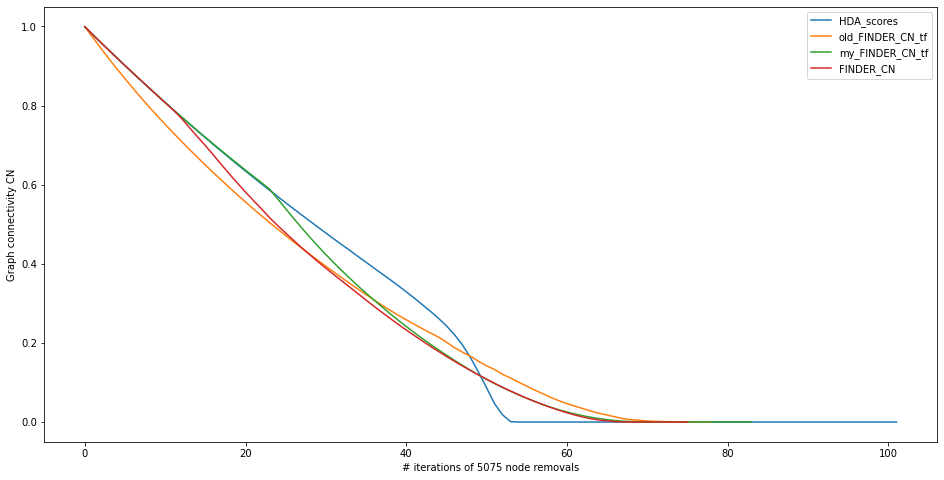

In [21]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))

#plt.plot(CN_scores, label='CN')
for key in exp_dict.keys():
    plt.plot(exp_dict[key], label=key)
    
#plt.plot(CI_scores, label='CI')
plt.legend()
plt.xlabel("# iterations of {} node removals".format(_k_node_removals))
plt.ylabel("Graph connectivity {}".format(experiment_type))

## Costed analysis


In [23]:
data_name = "modified-morPOP-NL-day20.txt"

In [24]:
network_file_name = "{}_degree".format(data_name)
network_file_path = "./data/real/cost/{}.gml".format(network_file_name)
G = nx.read_gml(network_file_path, destringizer=int)
print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())

_g_num_nodes = G.number_of_nodes()
_CN_denom = (((_g_num_nodes * (_g_num_nodes - 1))) /2)
_k_node_removals = int(_g_num_nodes * step_ratio)

print(_g_num_nodes)
def calc_graph_connectivity(G, experiment_type=experiment_type):
    if(G.number_of_nodes() in [0, 1]): return 0
    if(experiment_type=="CN"):
        pairwise_connectivity = 0
        for i in list(nx.connected_components(G)): pairwise_connectivity += (len(i) * (len(i) -1)) / 2
        pc = pairwise_connectivity / _CN_denom
        return pc
    else:
        maxCC = len(max(nx.connected_components(G), key=len))
        #print(maxCC , _g_num_nodes)
        return maxCC / _g_num_nodes

IOStream.flush timed out


Number of nodes in the graph: 507503
Number of edges in the graph: 3269669
507503


In [25]:
SUM_COST = 0
for i in range(len(G.nodes())):
    SUM_COST += G.nodes[i]['weight']

print(SUM_COST)

10014.300153147547


In [26]:
max_cost = 0
for i in range(len(G.nodes())):
    curr_cost = G.nodes[i]['weight']
    if(curr_cost > max_cost): max_cost = curr_cost

print(max_cost)

1.0


In [27]:
#  adaptive baselines
def cost_AdaptiveBaselines(G, k=_k_node_removals, approach='HDA', write=False):
    connectivity_scores_list = []
    cost_list = [0]
    connectivity_scores_list.append(calc_graph_connectivity(G))

    print("{} for k: {}".format(approach, k))

    while(True):
        print("- ", end="")
        if(approach=='HDA'):
            node_scores = dict(G.degree)

        node_scores_sorted = list(sorted(node_scores.items(), key=lambda item: item[1], reverse=True))
        isTerminal = k > len(node_scores_sorted)

        num_removals = int(min(k, len(node_scores_sorted)))
        node_score_pairs = node_scores_sorted[0:num_removals]
        node_removals = [i[0] for i in node_score_pairs]

        curr_cost = cost_list[-1]
        for n in node_removals:
            curr_cost += G.nodes[n]['weight']
        
        cost_list.append(curr_cost)

        G.remove_nodes_from(node_removals)

        connectivity_scores_list.append(calc_graph_connectivity(G))

        if(isTerminal): break

    print("\t-Finished calculations")

    if(write):
        result_file = os.path.join(HDA_export_path, "{}_scores_k_{}.txt".format(data_name, k))
        with open(result_file, 'w') as f_out:
                for j in range(len(connectivity_scores_list)):
                    f_out.write('%.8f\n' % connectivity_scores_list[j])
        print("\t-Finished export")

    return connectivity_scores_list, cost_list

In [35]:
def cost_calc_score_from_nodes_file(G, node_files, export_path, k=_k_node_removals, write=False):
    pairwise_conn_list = []
    cost_list = [0]
    pairwise_conn_list.append(calc_graph_connectivity(G))

    f = open(node_files,'r')
    node_removals = []
    for node in f:
        node_removals.append(int(node))

    
    while(True):
        print("- ", end="")

        isTerminal = k > len(node_removals)

        num_removals = int(min(k, len(node_removals)))
        curr_node_removals = node_removals[0:num_removals]
        #print(curr_node_removals)
        #print("=======")

        curr_cost = cost_list[-1]
        for n in curr_node_removals:
            curr_cost += G.nodes[n]['weight']
        
        cost_list.append(curr_cost)

        G.remove_nodes_from(curr_node_removals)

        pairwise_conn_list.append(calc_graph_connectivity(G))

        node_removals = node_removals[num_removals:]
        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(export_path, "scores_k_{}.txt".format(k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return pairwise_conn_list, cost_list

In [29]:
G = nx.read_gml(network_file_path, destringizer=int)

IOStream.flush timed out
IOStream.flush timed out


In [32]:
%%time
HDA_scores, HDA_costs = cost_AdaptiveBaselines(G, k=_k_node_removals,approach='HDA', write=False)


HDA for k: 5075
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
CPU times: user 56 s, sys: 191 ms, total: 56.2 s
Wall time: 56.2 s


In [33]:
for i in range(len(HDA_costs)): HDA_costs[i] =  HDA_costs[i]/SUM_COST

In [42]:
cost_exp_dict = {
                "HDA_robustness_l": [HDA_costs,HDA_scores],
                
                }

In [43]:
result_folders = ['old_FINDER_CN_cost_tf', 'my_FINDER_CN_cost_tf', 'FINDER_CN_cost', ]

for weight_type in ['degree']:
    for r_f in result_folders:
        network_file_name = "{}_{}".format(data_name, weight_type)

        torch_FINDER_nodefile_degree_scores = None
        FINDER_torch_file_path = os.path.join(".", "code", "results", r_f, 'real', 'Data_{}'.format(weight_type),\
                                    'StepRatio_0.0100', '{}.txt'.format(network_file_name))

        G = nx.read_gml(network_file_path, destringizer=int)

        curr_sccores, curr_costs = cost_calc_score_from_nodes_file(G, FINDER_torch_file_path, None, k=_k_node_removals, write=False)
        for i in range(len(curr_costs)): curr_costs[i] =  curr_costs[i]/SUM_COST
        cost_exp_dict[r_f] = [curr_costs, curr_sccores]


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations


Text(0, 0.5, 'Graph connectivity CN')

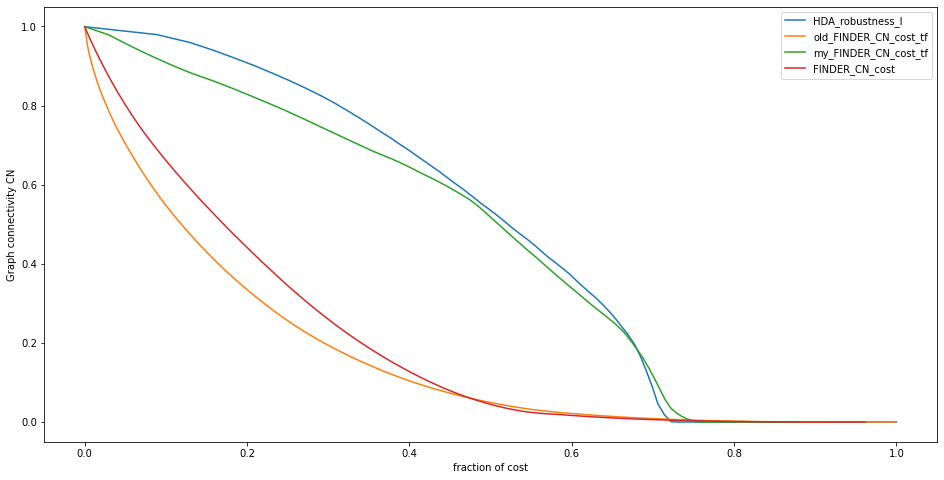

In [47]:

from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))

for key in cost_exp_dict.keys():
    plt.plot(cost_exp_dict[key][0], cost_exp_dict[key][1], label=key)

plt.legend()
plt.xlabel("fraction of cost")
plt.ylabel("Graph connectivity {}".format(experiment_type))

Text(0, 0.5, 'Graph connectivity CN')

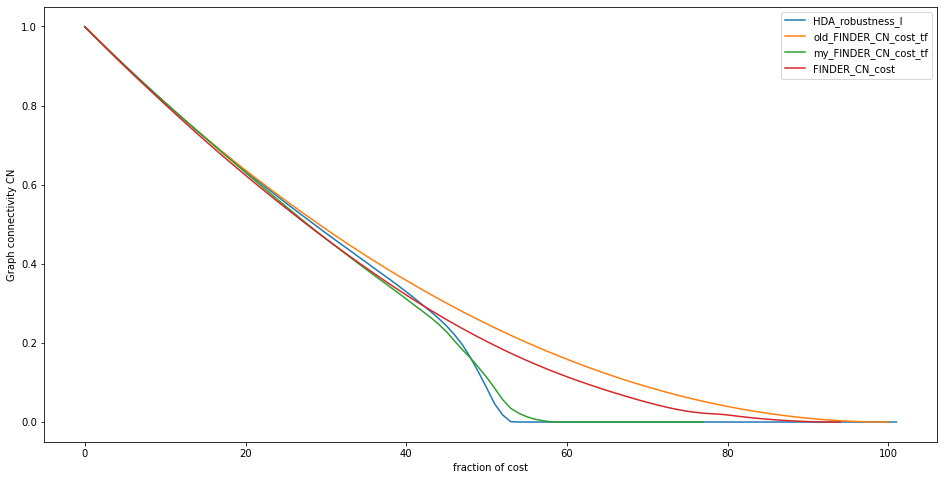

In [46]:

from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))

for key in cost_exp_dict.keys():
    plt.plot(cost_exp_dict[key][1], label=key)

plt.legend()
plt.xlabel("fraction of cost")
plt.ylabel("Graph connectivity {}".format(experiment_type))

In [40]:
network_file_path

'./data/real/cost/modified-morPOP-NL-day20.txt_degree.gml'